# Unbalanced Data in Insurance: Generative Adversarial Network
This notebook compares different approach for dealing unbalanced data in Insurance domain ([Kaggle Competition](https://www.kaggle.com/competitions/playground-series-s4e7/overview)). \
Original Dataset:
- https://www.kaggle.com/datasets/annantkumarsingh/health-insurance-cross-sell-prediction-data

References:
- https://towardsdatascience.com/generative-ai-synthetic-data-generation-with-gans-using-pytorch-2e4dde8a17dd
- https://medium.com/@tanayagrawal/train-your-first-gan-model-from-scratch-using-pytorch-9b72987fd2c0
- Walter Reade, Ashley Chow. (2024). Binary Classification of Insurance Cross Selling . Kaggle. https://kaggle.com/competitions/playground-series-s4e7

In [ ]:
!pip install kaggle

In [ ]:
from dotenv import load_dotenv
load_dotenv()

import os
import kaggle as kg
import pandas as pd
import numpy as np
import re
import string
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)

import warnings
warnings.filterwarnings("ignore")
# Visulalization
%matplotlib inline
matplotlib.rc(("xtick", "ytick", "text"), c="k")
matplotlib.rc("figure", dpi=80)

# Packages options
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all
np.seterr(divide='ignore', invalid='ignore', over='ignore') ;


import torch
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import torch.nn.init as init
from torch.utils.data import Dataset


kg.api.authenticate()

## Download Dataset

In [ ]:
DATASET_NAME = "annantkumarsingh/health-insurance-cross-sell-prediction-data"

In [ ]:
kg.api.dataset_download_files(dataset=DATASET_NAME, path='on.zip', unzip=True)

2024-07-21 08:24:08,927 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /api/v1/datasets/download/annantkumarsingh/health-insurance-cross-sell-prediction-data?datasetVersionNumber=None


Dataset URL: https://www.kaggle.com/datasets/annantkumarsingh/health-insurance-cross-sell-prediction-data


In [ ]:
df_train = pd.read_csv('on.zip/train.csv', encoding='ISO-8859-1')
df_train["is_train"] = True

df_test = pd.read_csv('on.zip/test.csv', encoding='ISO-8859-1')
df_test["is_train"] = False

In [ ]:
df_train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [ ]:
df_train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
is_train                0
dtype: int64

## Data Cleaning and Preprocessing
See [Variable Description](https://github.com/ankit986/HEALTH-INSURANCE-CROSS-SELL-PREDICTION)

### Data Preprocessing

In [ ]:
def encode_categorical_features(dataframe):
    gender_mapping = {'Male': 0, 'Female': 1}
    vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
    vehicle_damage_mapping = {'No': 0, 'Yes': 1}

    dataframe['Gender'] = dataframe['Gender'].map(gender_mapping)
    dataframe['Vehicle_Age'] = dataframe['Vehicle_Age'].map(vehicle_age_mapping)
    dataframe['Vehicle_Damage'] = dataframe['Vehicle_Damage'].map(vehicle_damage_mapping)

    return dataframe


def convert_data_types(dataframe):
    dataframe['Region_Code'] = dataframe['Region_Code'].astype(int)
    dataframe['Annual_Premium'] = dataframe['Annual_Premium'].astype(int)
    dataframe['Policy_Sales_Channel'] = dataframe['Policy_Sales_Channel'].astype(int)

    return dataframe


# Preprocessing steps
df_train = encode_categorical_features(df_train)
df_test = encode_categorical_features(df_test)


numerical_features = ['Age', 'Annual_Premium', 'Vintage']
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', "Region_Code"]
df_train = pd.get_dummies(df_train, columns=categorical_features, dtype=int)
df_test = pd.get_dummies(df_test, columns=categorical_features, dtype=int)

scaler = PowerTransformer(method='yeo-johnson', standardize=True)
df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])

In [ ]:
df_train.head(2)

,id,Age,Driving_License,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_0,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
0,1,0.571865,1,0,0.612207,26.0,0.765850,1,True,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1.765186,1,0,0.243028,26.0,0.403354,0,True,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test.head(2)

,id,Age,Driving_License,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,is_train,Gender_0,Gender_1,...,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
0,381110,-0.929178,1,1,0.364892,152.0,-1.225453,False,1,0,...,0,0,0,0,0,0,0,0,0,0
1,381111,0.338874,1,0,0.255353,7.0,-0.433475,False,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train.columns

Index(['id', 'Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'is_train', 'Gender_0',
       'Gender_1', 'Vehicle_Age_0', 'Vehicle_Age_1', 'Vehicle_Age_2',
       'Vehicle_Damage_0', 'Vehicle_Damage_1', 'Region_Code_0.0',
       'Region_Code_1.0', 'Region_Code_2.0', 'Region_Code_3.0',
       'Region_Code_4.0', 'Region_Code_5.0', 'Region_Code_6.0',
       'Region_Code_7.0', 'Region_Code_8.0', 'Region_Code_9.0',
       'Region_Code_10.0', 'Region_Code_11.0', 'Region_Code_12.0',
       'Region_Code_13.0', 'Region_Code_14.0', 'Region_Code_15.0',
       'Region_Code_16.0', 'Region_Code_17.0', 'Region_Code_18.0',
       'Region_Code_19.0', 'Region_Code_20.0', 'Region_Code_21.0',
       'Region_Code_22.0', 'Region_Code_23.0', 'Region_Code_24.0',
       'Region_Code_25.0', 'Region_Code_26.0', 'Region_Code_27.0',
       'Region_Code_28.0', 'Region_Code_29.0', 'Region_Code_30.0',
       'Region_Code_31.0', 'Region_Code_32.0',

In [ ]:
df_test.columns

Index(['id', 'Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'is_train', 'Gender_0', 'Gender_1',
       'Vehicle_Age_0', 'Vehicle_Age_1', 'Vehicle_Age_2', 'Vehicle_Damage_0',
       'Vehicle_Damage_1', 'Region_Code_0.0', 'Region_Code_1.0',
       'Region_Code_2.0', 'Region_Code_3.0', 'Region_Code_4.0',
       'Region_Code_5.0', 'Region_Code_6.0', 'Region_Code_7.0',
       'Region_Code_8.0', 'Region_Code_9.0', 'Region_Code_10.0',
       'Region_Code_11.0', 'Region_Code_12.0', 'Region_Code_13.0',
       'Region_Code_14.0', 'Region_Code_15.0', 'Region_Code_16.0',
       'Region_Code_17.0', 'Region_Code_18.0', 'Region_Code_19.0',
       'Region_Code_20.0', 'Region_Code_21.0', 'Region_Code_22.0',
       'Region_Code_23.0', 'Region_Code_24.0', 'Region_Code_25.0',
       'Region_Code_26.0', 'Region_Code_27.0', 'Region_Code_28.0',
       'Region_Code_29.0', 'Region_Code_30.0', 'Region_Code_31.0',
       'Region_Code_32.0', 'Region_Cod

In [ ]:
class ClipOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 lower_quantile,
                 upper_quantile,
                 multiply_by=1.5,
                 replace_with_median: bool = False):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.multiply_by = multiply_by
        self.replace_with_median = replace_with_median

        self.lower_limit = 0
        self.upper_limit = 0
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        q1, q3 = np.quantile(X, [self.lower_quantile, self.upper_quantile])
        iqr = q3 - q1
        self.lower_limit = q1 - (self.multiply_by * iqr)
        self.upper_limit = q3 + (self.multiply_by * iqr)
        return self

    def transform(self, X):
        if self.replace_with_median:
            return np.where(
                ((X >= self.lower_limit) & (X <= self.upper_limit)), X,
                np.median(X))
        else:
            return np.clip(X, self.lower_limit, self.upper_limit)


def get_skewness(df, lower=None, upper=None):
    columns = df.columns
    skewness: pd.Series = df[columns].skew()
    highly_skewed = skewness[(skewness <= lower) |
                             (skewness >= upper)].index.to_list()
    lowly_skewed = skewness[(skewness > lower)
                            & (skewness < upper)].index.to_list()
    return (highly_skewed, lowly_skewed)


def remove_outliers(df: pd.DataFrame, numerical_features: list, lower: float, upper: float, target: str = "Response"):
    highly_skewed, lowly_skewed = get_skewness(df[numerical_features],
                                               lower=lower,
                                               upper=upper)
    df[highly_skewed] = df[highly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=True).
        fit_transform(x))

    df[lowly_skewed] = df[lowly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=False).
        fit_transform(x))
    return df

In [ ]:
numerical_features = ['Annual_Premium', 'Vintage']
LOWER = -0.9
UPPER = 0.9

df_train = remove_outliers(
    df=df_train,
    numerical_features=numerical_features,
    lower=LOWER,
    upper=UPPER,
)

In [ ]:
df_train["Response"].value_counts(normalize=True)

Response
0    0.877437
1    0.122563
Name: proportion, dtype: float64

## Modeling
We train XGBoost model. Minority classes are oversampled via SMOTE

In [ ]:
TARGET = "Response"
col_to_drop_train = ["id", TARGET, "is_train"]
col_to_drop_test = ["id", "is_train"]

In [ ]:
X_train, y_train = df_train.drop(columns=col_to_drop_train).values, df_train[TARGET]
X_test = df_test.drop(columns=col_to_drop_test).values
assert X_train.shape[1] == X_test.shape[1]

rus = SMOTE(sampling_strategy='auto')
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
y_train_rus.value_counts(normalize=True)

Response
1    0.5
0    0.5
Name: proportion, dtype: float64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_rus, y_train_rus, test_size=0.2, random_state=42,stratify=y_train_rus)

In [ ]:
scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_val = scalar.transform(X_val)

In [ ]:
res = dict()

model = XGBClassifier(n_jobs=-1)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

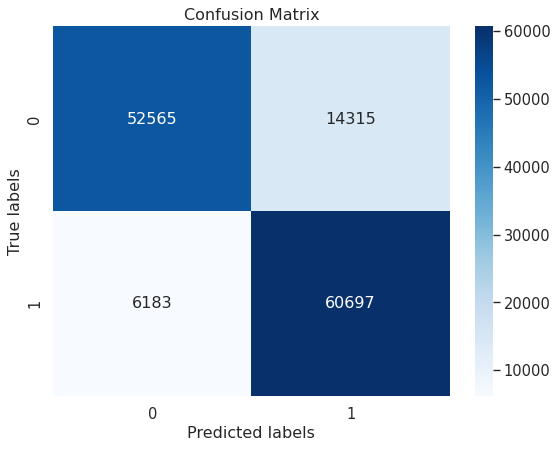

,0,1,accuracy,macro avg,weighted avg
precision,0.894754,0.809164,0.846755,0.851959,0.851959
recall,0.785960,0.907551,0.846755,0.846755,0.846755
f1-score,0.836836,0.855538,0.846755,0.846187,0.846187
support,66880.000000,66880.000000,0.846755,133760.000000,133760.000000


In [ ]:
report = classification_report(y_val, y_pred, output_dict=True)
res["precision"] = report["weighted avg"]["precision"]
res["recall"] = report["weighted avg"]["recall"]
res["f1_score"] = report["weighted avg"]["f1-score"]
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

report_df = pd.DataFrame(report)
report_df

## Synthetic Data Generation via GAN
We generate synthetic data of minority classes via Generative Adversarial Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
#Creating a dataset

class MyDataset(Dataset):
    def __init__(self, data: np.ndarray):
        self.data = data.astype(float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        return sample


In [ ]:
df_train.columns

Index(['id', 'Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'is_train', 'Gender_0',
       'Gender_1', 'Vehicle_Age_0', 'Vehicle_Age_1', 'Vehicle_Age_2',
       'Vehicle_Damage_0', 'Vehicle_Damage_1', 'Region_Code_0.0',
       'Region_Code_1.0', 'Region_Code_2.0', 'Region_Code_3.0',
       'Region_Code_4.0', 'Region_Code_5.0', 'Region_Code_6.0',
       'Region_Code_7.0', 'Region_Code_8.0', 'Region_Code_9.0',
       'Region_Code_10.0', 'Region_Code_11.0', 'Region_Code_12.0',
       'Region_Code_13.0', 'Region_Code_14.0', 'Region_Code_15.0',
       'Region_Code_16.0', 'Region_Code_17.0', 'Region_Code_18.0',
       'Region_Code_19.0', 'Region_Code_20.0', 'Region_Code_21.0',
       'Region_Code_22.0', 'Region_Code_23.0', 'Region_Code_24.0',
       'Region_Code_25.0', 'Region_Code_26.0', 'Region_Code_27.0',
       'Region_Code_28.0', 'Region_Code_29.0', 'Region_Code_30.0',
       'Region_Code_31.0', 'Region_Code_32.0',

In [ ]:
import torch.optim as optim

# Hyperparameters
BATCH_SIZE = 8
EPOCHS = 10
lr_gen = 1e-5
lr_dis = 1e-5

# Other params
noise_dim = 66
num_features = 66
latent_dim  = noise_dim

critic_iterations = 5
weight_clip = 0.01

def make_some_noise(BATCH_SIZE, noise_dim):
    return torch.randn(BATCH_SIZE,noise_dim)

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

generator = Generator(noise_dim, num_features)
discriminator = Discriminator(num_features)

# generator = generator.apply(weights_init)
# discriminator = discriminator.apply(weights_init)

In [ ]:
criterion = nn.BCELoss()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_dis, betas=(0.5, 0.999))

# gen_optimizer = torch.optim.RMSprop(generator.parameters(), lr=lr_gen)
# disc_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=lr_dis)

### Upselling Customers (class = 1) Training

In [ ]:
class_id = 1
X_train = df_train.query(f"{TARGET}==@class_id").drop(columns=col_to_drop_train).values
scaler = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scaler.transform(X_train)

In [ ]:
# Create an instance of the dataset
dataset_gan = MyDataset(X_train)

# Create DataLoader
dataloader_gan = DataLoader(dataset_gan, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
for batch in tqdm(dataloader_gan, total=len(dataloader_gan)):
  print(batch.size())
  break

  0%|          | 0/5838 [00:00<?, ?it/s]

torch.Size([8, 66])


In [ ]:
gen_loss_list = []
dis_loss_real_list = []
dis_loss_fake_list = []

for epoch in range(EPOCHS):
  for batch in tqdm(dataloader_gan, total=len(dataloader_gan)):
    # Train Discriminator on real data
    disc_optimizer.zero_grad()
    real_labels = torch.ones(BATCH_SIZE, 1)
    fake_labels = torch.zeros(BATCH_SIZE, 1)

    dis_real_out = discriminator(batch)
    dis_real_loss = criterion(dis_real_out, real_labels)
    dis_real_loss.backward()

    # Train Discriminator on data produced by Generator
    inp_fake_x_gen = make_some_noise(BATCH_SIZE=BATCH_SIZE, noise_dim=noise_dim)
    dis_inp_fake_x = generator(inp_fake_x_gen).detach()
    dis_fake_out = discriminator(dis_inp_fake_x)
    dis_fake_loss = criterion(dis_fake_out, fake_labels)
    dis_fake_loss.backward()

    disc_optimizer.step()

    # Training Generator
    gen_optimizer.zero_grad()
    gen_inp = make_some_noise(BATCH_SIZE=BATCH_SIZE, noise_dim=noise_dim)
    gen_out = generator(gen_inp)
    dis_out_gen_training = discriminator(gen_out)
    gen_loss = criterion(dis_out_gen_training, real_labels)  # Use the same real_labels as above

    gen_loss.backward()
    gen_optimizer.step()

  print(f"Epoch {epoch}, D Loss Real: {dis_real_loss.item()}, D Loss Fake: {dis_fake_loss.item()}, G Loss: {gen_loss.item()}")
  gen_loss_list.append(gen_loss.item())
  dis_loss_real_list.append(dis_real_loss.item())
  dis_loss_fake_list.append(dis_fake_loss.item())

  0%|          | 0/5838 [00:00<?, ?it/s]

Epoch 0, D Loss Real: 0.5509266257286072, D Loss Fake: 0.7158703207969666, G Loss: 0.6617411375045776


  0%|          | 0/5838 [00:00<?, ?it/s]

Epoch 1, D Loss Real: 0.5199832916259766, D Loss Fake: 0.9262192249298096, G Loss: 0.5135654211044312


  0%|          | 0/5838 [00:00<?, ?it/s]

Epoch 2, D Loss Real: 0.58974289894104, D Loss Fake: 0.6892964839935303, G Loss: 0.6998748183250427


  0%|          | 0/5838 [00:00<?, ?it/s]

Epoch 3, D Loss Real: 0.6162651777267456, D Loss Fake: 0.733968198299408, G Loss: 0.6459215879440308


  0%|          | 0/5838 [00:00<?, ?it/s]

Epoch 4, D Loss Real: 0.6979766488075256, D Loss Fake: 0.7642144560813904, G Loss: 0.6339648962020874


  0%|          | 0/5838 [00:00<?, ?it/s]

Epoch 5, D Loss Real: 0.7567527890205383, D Loss Fake: 0.626122236251831, G Loss: 0.7628821134567261


  0%|          | 0/5838 [00:00<?, ?it/s]

Epoch 6, D Loss Real: 0.6899223923683167, D Loss Fake: 0.6496714353561401, G Loss: 0.7389756441116333


  0%|          | 0/5838 [00:00<?, ?it/s]

Epoch 7, D Loss Real: 0.695081889629364, D Loss Fake: 0.7005841732025146, G Loss: 0.6857799887657166


  0%|          | 0/5838 [00:00<?, ?it/s]

Epoch 8, D Loss Real: 0.6221910119056702, D Loss Fake: 0.9587993621826172, G Loss: 0.48285946249961853


  0%|          | 0/5838 [00:00<?, ?it/s]

Epoch 9, D Loss Real: 0.6374744176864624, D Loss Fake: 0.6482822895050049, G Loss: 0.7381892800331116


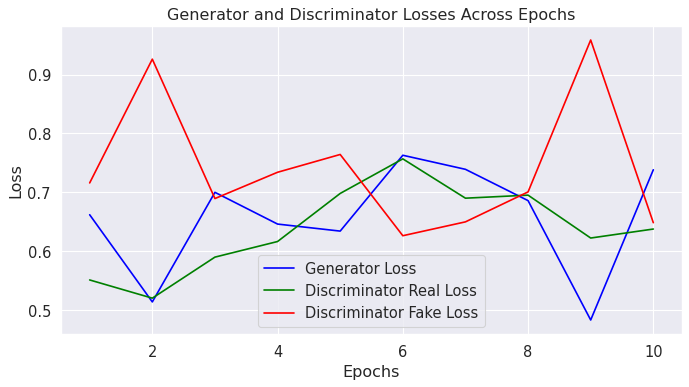

In [ ]:
total_epochs = [int(i+1) for i in range(EPOCHS)]
plt.figure(figsize=(10, 5))
plt.plot(total_epochs, gen_loss_list, label='Generator Loss', color='blue')
plt.plot(total_epochs, dis_loss_real_list, label='Discriminator Real Loss', color='green')
plt.plot(total_epochs, dis_loss_fake_list, label='Discriminator Fake Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Good Scores (class = 2) Training

In [ ]:
class_id = 2
X_train = df_train.query("Credit_Score==@class_id").drop(columns=["Credit_Score", "Credit_Mix"]).values
scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
print(f"Original rows: {X_train.shape[0]}")

# Create an instance of the dataset
dataset_good = MyDataset(X_train)

# Create DataLoader
dataloader_good = DataLoader(dataset_good, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Original rows: 17828


In [ ]:
# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 10
lr_gen = 1e-4
lr_dis = 1e-4

# Other params
noise_dim = 39
num_features = 39

def make_some_noise():
    return torch.randn(BATCH_SIZE,noise_dim)

generator_good = Generator(noise_dim, num_features)
discriminator_good = Discriminator(num_features)

criterion = nn.BCELoss()
gen_optimizer_good = torch.optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
disc_optimizer_good = torch.optim.Adam(discriminator.parameters(), lr=lr_dis, betas=(0.5, 0.999))

In [ ]:
criterion = nn.BCELoss()
gen_optimizer_good = torch.optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
disc_optimizer_good = torch.optim.Adam(discriminator.parameters(), lr=lr_dis, betas=(0.5, 0.999))

In [ ]:
gen_loss_list = []
dis_loss_real_list = []
dis_loss_fake_list = []

for epoch in range(EPOCHS):
  for batch in tqdm(dataloader_good, total=len(dataloader_good)):
    # Train Discriminator on real data
    disc_optimizer.zero_grad()
    real_labels = torch.ones(BATCH_SIZE, 1) * 0.9  # Label smoothing
    fake_labels = torch.zeros(BATCH_SIZE, 1) + 0.1  # Label smoothing

    dis_real_out = discriminator_good(batch)
    dis_real_loss = criterion(dis_real_out, real_labels)
    dis_real_loss.backward()

    # Train Discriminator on data produced by Generator
    inp_fake_x_gen = make_some_noise()
    dis_inp_fake_x = generator_good(inp_fake_x_gen).detach()
    dis_fake_out = discriminator_good(dis_inp_fake_x)
    dis_fake_loss = criterion(dis_fake_out, fake_labels)
    dis_fake_loss.backward()

    disc_optimizer.step()

    # Training Generator
    gen_optimizer.zero_grad()
    gen_inp = make_some_noise()
    gen_out = generator_good(gen_inp)
    dis_out_gen_training = discriminator(gen_out)
    gen_loss = criterion(dis_out_gen_training, real_labels)  # Use the same real_labels as above

    gen_loss.backward()
    gen_optimizer.step()

  print(f"Epoch {epoch}, D Loss Real: {dis_real_loss.item()}, D Loss Fake: {dis_fake_loss.item()}, G Loss: {gen_loss.item()}")
  gen_loss_list.append(gen_loss.item())
  dis_loss_real_list.append(dis_real_loss.item())
  dis_loss_fake_list.append(dis_fake_loss.item())

### Generated Data
Once GAN is trained, we generate new synthetic data from Generator. Here are the detailed steps and considerations:
- **Generate Synthetic Data**: Generate data using the trained generator
- **Inverse Transform**: Use the scaler's inverse transformation to bring the data back to the original scale
- **Convert Binary Variables**: For the binary variables, convert the values to either 0 or 1 based on a threshold

In [ ]:
class DataGenerator:
  def __init__(self, generator, scaler, num_cols, binary_cols, class_id: int):
    self.generator = generator
    self.scaler = scaler
    self.num_cols = num_cols
    self.binary_cols = binary_cols
    self.class_id = class_id


  def make_some_noise(self, n_rows):
    return torch.randn(n_rows, self.num_cols)


  def generate(self, n_rows):
    gen_inp = self.make_some_noise(n_rows)
    generated_data = self.generator(gen_inp).detach().numpy()
    generated_data = self.scaler.inverse_transform(generated_data)
    for col in self.binary_cols:
      generated_data[:, col] = (generated_data[:, col] > 0).astype(int)
    return generated_data, np.array([self.class_id for _ in range(generated_data.shape[0])])

In [ ]:
df_train.columns, col_to_drop_train

(Index(['id', 'Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium',
        'Policy_Sales_Channel', 'Vintage', 'Response', 'is_train', 'Gender_0',
        'Gender_1', 'Vehicle_Age_0', 'Vehicle_Age_1', 'Vehicle_Age_2',
        'Vehicle_Damage_0', 'Vehicle_Damage_1', 'Region_Code_0.0',
        'Region_Code_1.0', 'Region_Code_2.0', 'Region_Code_3.0',
        'Region_Code_4.0', 'Region_Code_5.0', 'Region_Code_6.0',
        'Region_Code_7.0', 'Region_Code_8.0', 'Region_Code_9.0',
        'Region_Code_10.0', 'Region_Code_11.0', 'Region_Code_12.0',
        'Region_Code_13.0', 'Region_Code_14.0', 'Region_Code_15.0',
        'Region_Code_16.0', 'Region_Code_17.0', 'Region_Code_18.0',
        'Region_Code_19.0', 'Region_Code_20.0', 'Region_Code_21.0',
        'Region_Code_22.0', 'Region_Code_23.0', 'Region_Code_24.0',
        'Region_Code_25.0', 'Region_Code_26.0', 'Region_Code_27.0',
        'Region_Code_28.0', 'Region_Code_29.0', 'Region_Code_30.0',
        'Region_Code_31.0', 'Reg

In [ ]:
df_train_drop = df_train.drop(columns=col_to_drop_train)
dummy_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Previously_Insured']
CLASS_ID = 1

binary_cols = []
for df_cols in df_train_drop:
  for c in dummy_cols:
    if c in df_cols:
      binary_cols.append(df_train_drop.columns.get_loc(df_cols))

New_X_train, New_y_train = df_train_drop.values , df_train[TARGET]

synthetic_generator = DataGenerator(
    generator=generator,
    scaler=scaler,
    num_cols=New_X_train.shape[1],
    binary_cols=binary_cols,
    class_id=CLASS_ID,
)

In [ ]:
n_rows = df_train[TARGET].value_counts()[0] - df_train[TARGET].value_counts()[1]
generated_data, synthetic_labels = synthetic_generator.generate(n_rows=n_rows)

In [ ]:
synthetic_labels.shape

(287689,)

In [ ]:
# Append generated data and labels
X_train_augmented = np.vstack((New_X_train, generated_data))
y_train_augmented = np.hstack((New_y_train, synthetic_labels))

### Comparing distributions

In [ ]:
df_train_augmented = pd.DataFrame(generated_data, columns=df_train_drop.columns)
# df_train_augmented["Credit_Score"] = "Poor"

df_train_compare = df_train.drop(columns=[col for col in col_to_drop_train if col != TARGET])
original_target = df_train_compare[df_train_compare[TARGET]==CLASS_ID]

In [ ]:
df_train_augmented["Previously_Insured"].value_counts()

Previously_Insured
1.0    287689
Name: count, dtype: int64

In [ ]:
original_target["Previously_Insured"].value_counts()

Previously_Insured
0    46552
1      158
Name: count, dtype: int64

In [ ]:
original_target.columns

Index(['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'Gender_0', 'Gender_1',
       'Vehicle_Age_0', 'Vehicle_Age_1', 'Vehicle_Age_2', 'Vehicle_Damage_0',
       'Vehicle_Damage_1', 'Region_Code_0.0', 'Region_Code_1.0',
       'Region_Code_2.0', 'Region_Code_3.0', 'Region_Code_4.0',
       'Region_Code_5.0', 'Region_Code_6.0', 'Region_Code_7.0',
       'Region_Code_8.0', 'Region_Code_9.0', 'Region_Code_10.0',
       'Region_Code_11.0', 'Region_Code_12.0', 'Region_Code_13.0',
       'Region_Code_14.0', 'Region_Code_15.0', 'Region_Code_16.0',
       'Region_Code_17.0', 'Region_Code_18.0', 'Region_Code_19.0',
       'Region_Code_20.0', 'Region_Code_21.0', 'Region_Code_22.0',
       'Region_Code_23.0', 'Region_Code_24.0', 'Region_Code_25.0',
       'Region_Code_26.0', 'Region_Code_27.0', 'Region_Code_28.0',
       'Region_Code_29.0', 'Region_Code_30.0', 'Region_Code_31.0',
       'Region_Code_32.0', 'Region_Code_33.0

In [ ]:
df_train_augmented.columns

Index(['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Gender_0', 'Gender_1',
       'Vehicle_Age_0', 'Vehicle_Age_1', 'Vehicle_Age_2', 'Vehicle_Damage_0',
       'Vehicle_Damage_1', 'Region_Code_0.0', 'Region_Code_1.0',
       'Region_Code_2.0', 'Region_Code_3.0', 'Region_Code_4.0',
       'Region_Code_5.0', 'Region_Code_6.0', 'Region_Code_7.0',
       'Region_Code_8.0', 'Region_Code_9.0', 'Region_Code_10.0',
       'Region_Code_11.0', 'Region_Code_12.0', 'Region_Code_13.0',
       'Region_Code_14.0', 'Region_Code_15.0', 'Region_Code_16.0',
       'Region_Code_17.0', 'Region_Code_18.0', 'Region_Code_19.0',
       'Region_Code_20.0', 'Region_Code_21.0', 'Region_Code_22.0',
       'Region_Code_23.0', 'Region_Code_24.0', 'Region_Code_25.0',
       'Region_Code_26.0', 'Region_Code_27.0', 'Region_Code_28.0',
       'Region_Code_29.0', 'Region_Code_30.0', 'Region_Code_31.0',
       'Region_Code_32.0', 'Region_Code_33.0', 'Region_C

In [ ]:
df_train_augmented["Age"].value_counts()

Age
-0.205128    7
-0.163337    7
-0.200201    7
-0.231114    7
-0.203843    7
            ..
-0.153442    1
-0.215634    1
-0.185087    1
-0.203925    1
-0.086574    1
Name: count, Length: 219108, dtype: int64

Feature: Age
ORIGINAL: count    46710.000000
mean         0.403196
std          0.737023
min         -1.604540
25%         -0.000884
50%          0.516379
75%          0.917626
max          1.936381
Name: Age, dtype: float64
GENERATED: count    287689.000000
mean         -0.181900
std           0.041245
min          -0.272670
25%          -0.212110
50%          -0.187779
75%          -0.158067
max           0.090978
Name: Age, dtype: float64

  KS Test: statistic=0.7668, p-value=0.0000
  T-test: statistic=171.5303, p-value=0.0000
  Mann-Whitney U Test: statistic=10791448298.0000, p-value=0.0000


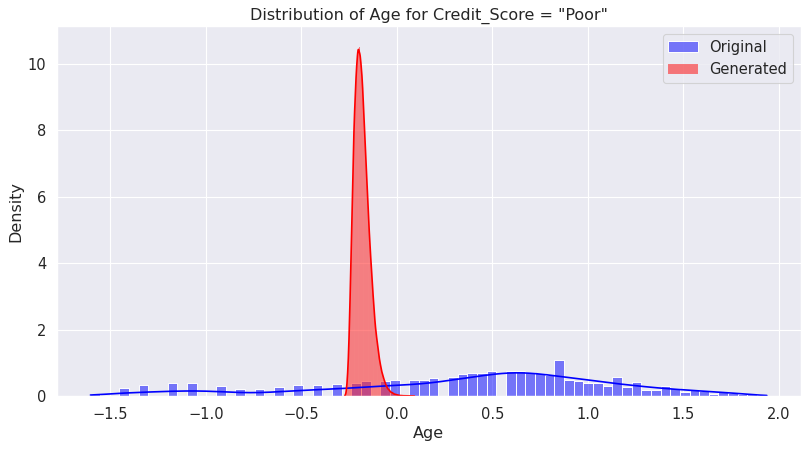

In [ ]:

from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu
FEATURES = ["Age"]

for feature in FEATURES:  # Exclude 'Credit_Score'
    print(f"Feature: {feature}")
    print(f"ORIGINAL: {original_target[feature].describe()}")
    print(f"GENERATED: {df_train_augmented[feature].describe()}")
    print()

    # Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = ks_2samp(original_target[feature], df_train_augmented[feature])
    print(f"  KS Test: statistic={ks_stat:.4f}, p-value={ks_pvalue:.4f}")

    # T-test
    t_stat, t_pvalue = ttest_ind(original_target[feature], df_train_augmented[feature], equal_var=False)
    print(f"  T-test: statistic={t_stat:.4f}, p-value={t_pvalue:.4f}")

    # Mann-Whitney U Test
    mw_stat, mw_pvalue = mannwhitneyu(original_target[feature], df_train_augmented[feature])
    print(f"  Mann-Whitney U Test: statistic={mw_stat:.4f}, p-value={mw_pvalue:.4f}")

    # Plot distributions
    plt.figure(figsize=(12, 6))
    sns.histplot(original_target[feature], color='blue', kde=True, label='Original', stat='density')
    sns.histplot(df_train_augmented[feature], color='red', kde=True, label='Generated', stat='density')
    plt.title(f'Distribution of {feature} for Credit_Score = "Poor"')
    plt.legend()
    plt.show()

## Train Model with Synthetic Data

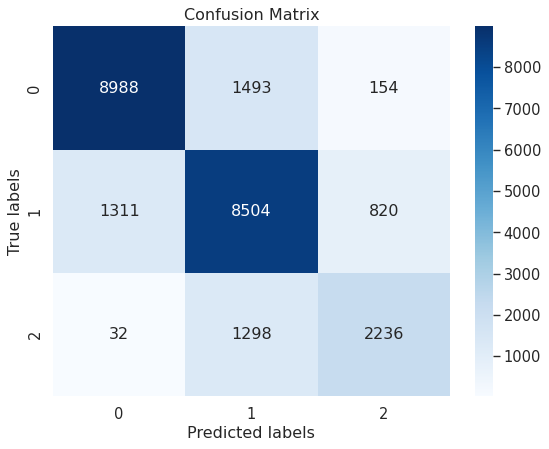

,0,1,2,accuracy,macro avg,weighted avg
precision,0.870003,0.752900,0.696573,0.794331,0.773159,0.794957
recall,0.845134,0.799624,0.627033,0.794331,0.757264,0.794331
f1-score,0.857388,0.775559,0.659976,0.794331,0.764308,0.794003
support,10635.000000,10635.000000,3566.000000,0.794331,24836.000000,24836.000000


In [ ]:
X_train_augmented, X_val_augmented, y_train_augmented, y_val_augmented = train_test_split(X_train_augmented, y_train_augmented, test_size=0.2, random_state=42,stratify=y_train_augmented)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train_augmented)
X_train_augmented = scalar.transform(X_train_augmented)
X_val_augmented = scalar.transform(X_val_augmented)

res_augmented = dict()
model = XGBClassifier(n_jobs=-1)
model.fit(X_train_augmented, y_train_augmented)
y_pred_augmented = model.predict(X_val_augmented)

report_augmented = classification_report(y_val_augmented, y_pred_augmented, output_dict=True)
res_augmented["precision"] = report_augmented["weighted avg"]["precision"]
res_augmented["recall"] = report_augmented["weighted avg"]["recall"]
res_augmented["f1_score"] = report_augmented["weighted avg"]["f1-score"]
cm_augmented = confusion_matrix(y_val_augmented, y_pred_augmented)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_augmented, annot=True, cmap="Blues", fmt="d", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

report_df_augmented = pd.DataFrame(report_augmented)
report_df_augmented